
# **Exercise 1. Autoencoder**



First exercise for the Project of DLAI Fall semester 2019/2020.

Authors:
*   Carlos Alejandro López Molina
*   María González i Calabuig
*   Roser Batlle Roca
*   Jordi Biosca Caro



Import of different libraries used to build the script:

In [0]:
import torch

import numpy as np
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data.sampler import SubsetRandomSampler
from tabulate import tabulate
import random

seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Definition of hyper-parameters:

In [0]:
hparams = {
    'batch_size': 64,
    'num_epochs': 5,
    'test_batch_size': 64,
    'hidden_size': 64,
    'hidden_size_2': 128,
    'hidden_size_3': 256,
    'num_classes': 10,
    'num_inputs': 1, 
    'learning_rate': 1e-3,
    'log_interval': 100,
    'num_workers': 4,
    'kernel_size': 3,
    'encoder_key': [1, 5, 25, 50, 100]
}

hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

**STEP 1** - Load MNIST data set and split the original training data.

In [0]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor()
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor()                                
                               ]))

num_train = len(mnist_trainset)
indices = list(range(num_train))
test_size = 0.05
split = int(np.floor(test_size * num_train))

train_id, test_id = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_id)

test_sampler = SubsetRandomSampler(test_id)

train_loader = torch.utils.data.DataLoader(mnist_trainset, 
                                           hparams['batch_size'], 
                                           shuffle=False,
                                           sampler=train_sampler,
                                           num_workers=hparams['num_workers'], 
                                           )

test_loader = torch.utils.data.DataLoader(mnist_trainset, 
                                          hparams['batch_size'], 
                                          shuffle=False,
                                          sampler=test_sampler,
                                          num_workers=hparams['num_workers'], 
                                          )


**STEP 2** - Autoencoder.

In [0]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)




class AutoEncoder_convolution(nn.Module):

  def __init__(self, encoder_key):
    super(AutoEncoder_convolution,self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(hparams['num_inputs'], hparams['hidden_size'], 4, padding=3, stride=2),
        nn.ReLU(True),
        nn.Conv2d(hparams['hidden_size'], hparams['hidden_size_2'], 4, padding=1, stride=2),
        nn.ReLU(True),
        nn.Conv2d(hparams['hidden_size_2'], hparams['hidden_size_3'], 4, stride=2),
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=1),
        nn.ReLU(True),
        nn.Flatten(),
        nn.Linear(2*2*hparams['hidden_size_3'], encoder_key)
    )

    self.decoder = nn.Sequential(
        nn.Linear(encoder_key, 2*2*hparams['hidden_size_3']),
        nn.ReLU(True),
        Reshape(-1,hparams['hidden_size_3'], 2, 2),
        nn.ConvTranspose2d(hparams['hidden_size_3'], hparams['hidden_size_2'], 3, stride=2),
        nn.ReLU(True),
        nn.ConvTranspose2d(hparams['hidden_size_2'], hparams['hidden_size'], 5, stride=3, padding=1),
        nn.ReLU(True),
        nn.ConvTranspose2d(hparams['hidden_size'], hparams['num_inputs'], 2, stride=2, padding=1),
        nn.Softmax(),
    )

  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

**STEP 3** - Autoencoder training. Different bottleneck sizes. 

We declare some variables to save the data:

In [0]:
losses_train = [[]for x in range(5)]
losses_test = [[]for x in range(5)]
model = [[]for x in range(5)]

In [0]:
# Trainning process
for key,i in zip(hparams['encoder_key'],range(5)):
  model[i] = AutoEncoder_convolution(key)
  model[i] = model[i].to(hparams['device'])
  distance = nn.SmoothL1Loss()
  optimizer = torch.optim.Adam(model[i].parameters(), lr=hparams['learning_rate'], weight_decay=1e-5)
  print('BOTTLENECK: ', key)
  for epoch in range (hparams['num_epochs']):
    for batch_id,data in enumerate(train_loader):
      img, _ = data
      img = img.to(hparams['device'])
      output = model[i](img)
      loss = distance(output, img)
      losses_train[i].append(loss.cpu().data.item())
      optimizer.zero_grad() 
      loss.backward()
      optimizer.step()
    for data in test_loader:
      img, _ = data
      img = img.to(hparams['device'])
      output = model[i](img)
      loss = distance(output, img)
      losses_test[i].append(loss.cpu().data.item())
      optimizer.zero_grad() 
      loss.backward()
      optimizer.step()

BOTTLENECK:  1


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


BOTTLENECK:  5
BOTTLENECK:  25
BOTTLENECK:  50
BOTTLENECK:  100


Plot of the training and validation losses for all the encoders:

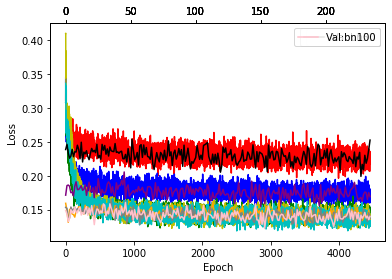

In [0]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
color_train = ['r', 'b', 'g', 'y', 'c']
color_test = ['black', 'Purple', 'orange', 'Gray', 'pink']
for i in range(5):
  ax1.plot(losses_train[i], label = 'Train:bn'+str(hparams['encoder_key'][i]), color= color_train[i])
  ax2 = ax1.twiny()
  ax2.plot(losses_test[i], label = 'Val:bn'+str(hparams['encoder_key'][i]), color=color_test[i])
  plt.legend()



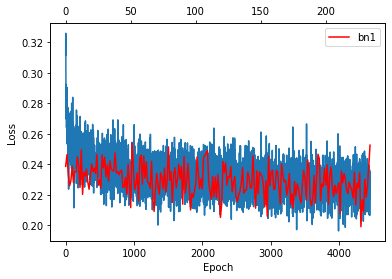

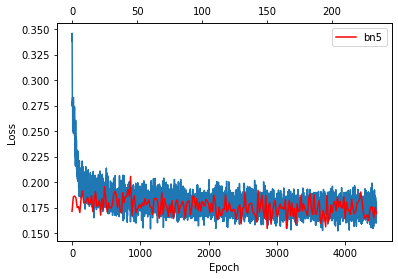

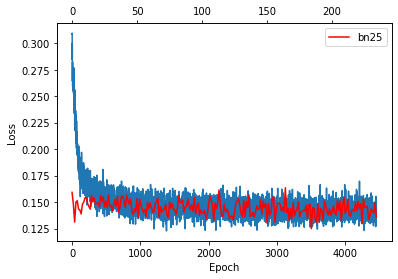

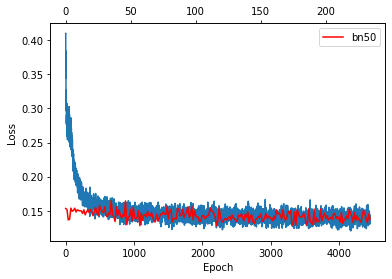

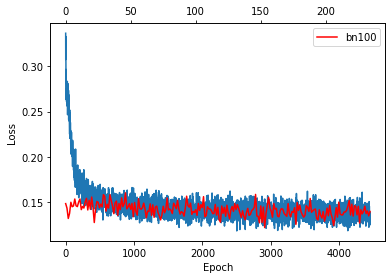

In [0]:
for i in range(5):
  fig, ax1 = plt.subplots()
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.plot(losses_train[i], label = 'bn'+str(hparams['encoder_key'][i]))
  ax2 = ax1.twiny()
  ax2.plot(losses_test[i], label = 'bn'+str(hparams['encoder_key'][i]), color='r')
  plt.legend()

Evaluation of the results:

In [0]:
loss = nn.MSELoss()
error = [[]for x in range(5)] 
num_param = [[]for x in range(5)]
for i in range(5):
    mse = 0
    for data in test_loader:
      img, label = data
      model[i].eval()
      model[i].to('cpu')
      output = model[i](img)
      mse += loss(img, output)
      
    num_param[i] = sum([p.data.nelement() for p in model[i].parameters()])
    error[i] = mse/len(test_loader)


In [0]:
# Table of conclusions
print(tabulate([[hparams['encoder_key'][0],num_param[0],error[0]], 
                [hparams['encoder_key'][1],num_param[1],error[1]],
                [hparams['encoder_key'][2],num_param[2],error[2]],
                [hparams['encoder_key'][3],num_param[3],error[3]],
                [hparams['encoder_key'][4],num_param[4],error[4]]], headers=['BottleNeck','# Parameters', 'MSE']))

Representation of the reconstruction of one autoencoder. We chose the one with the smallest MSE that best compresses the image, which corresponds to a bottleneck of size 25. (It compresses the image from 784 pixels to 100 pixels) 

In [0]:

for data in test_loader:
    img, _ = data
    model[2].eval()
    model[2].to('cpu')
    output = model[2](img)

    output = output.to('cpu')
    output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
for images, row in zip([img, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


Generation of 5 new images by injecting random values as input.

In [0]:
rand_img = 5*torch.rand(5,hparams['encoder_key'][2])
model[2].eval()
model[2].to('cpu')

output = model[2].decoder(rand_img)

output = output.to('cpu')
output = output.detach().numpy()

fig, axes = plt.subplots(5,figsize=(10,10))
for i in range(5):
  axes[i].imshow(np.squeeze(output[i, :]), cmap='gray')
